In [ ]:
import tensorflow_datasets as tfds
#import tensorflow_text as tf_text
from datetime import datetime
#!pip install tensorflow_datasets
#!pip install tensorflow-text
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Embedding,Dense,Conv2D,MaxPooling2D,Input,InputLayer,UpSampling2D,Flatten,Conv2DTranspose,Reshape
from tensorflow.keras import Sequential,layers
from keras.layers import LSTM
from tensorflow.keras import losses
import pandas as pd
print(tf.__version__)

2.18.0


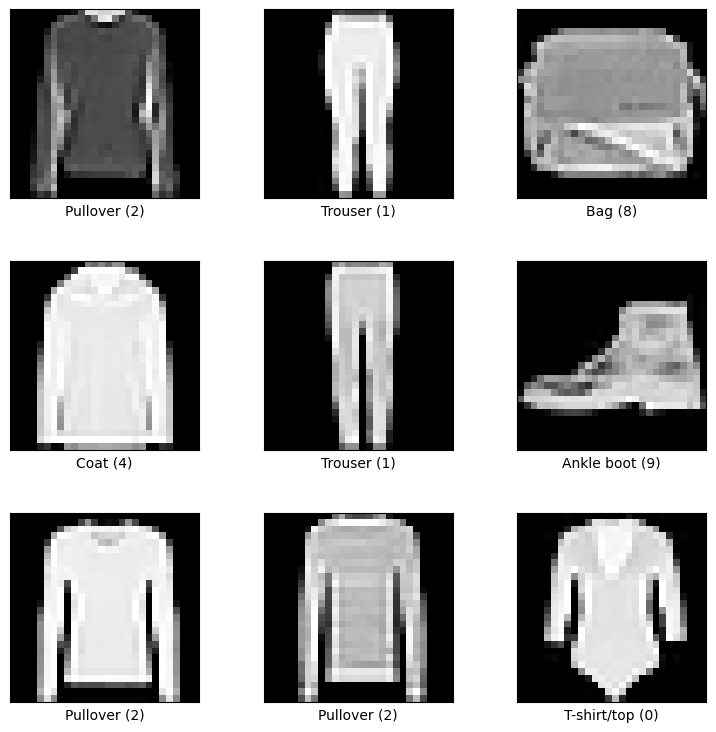

In [ ]:
(ds_train_, ds_val_,ds_test_,ds_unseen), ds_info = tfds.load(
    name = 'fashion_mnist',
    split=['train[:50%]', 'train[50%:60%]','train[60%:70%]','train[70%:80%]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True)
fig = tfds.show_examples(ds_train_, ds_info)

In [ ]:
ds_train_

<_PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
label_names = ds_info.features['label'].names
label_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
def augment_data(images, labels, get_label=False):
    if get_label:
        return tf.cast(images, tf.float32) / 255.,labels
    else:
        return tf.cast(images, tf.float32) / 255.,tf.cast(images, tf.float32) / 255.

In [ ]:
def data_load(data_ds,augmented=augment_data,shuffle_=True ,batch_=10,get_label=False):
    data_ds = data_ds.map(lambda x,y:
        augmented(x,y,get_label), num_parallel_calls=tf.data.AUTOTUNE)
    data_ds = data_ds.cache()
    if shuffle_:
        data_ds = data_ds.shuffle(len(data_ds))
    data_ds = data_ds.batch(batch_)
    data_ds = data_ds.prefetch(tf.data.AUTOTUNE)
    return data_ds

data_train = data_load(ds_train_)
data_val = data_load(ds_val_)
data_test = data_load(ds_test_,shuffle_=False)

data_unseen = data_load(ds_unseen, get_label=True )

In [ ]:
for ds,lb in data_train.take(1):
    shaped=ds.shape
print(shaped)

(10, 28, 28, 1)


In [ ]:
class MaxPool2x2(nn.Module):
    @nn.compact
    def __call__(self, x):
        return nn.max_pool(x, window_shape=(2, 2), strides=(2, 2), padding='SAME')

In [ ]:
import jax.numpy as jnp
from flax import linen as nn

class Upsample2x2(nn.Module):
    @nn.compact
    def __call__(self, x):
        return jnp.repeat(jnp.repeat(x, 2, axis=1), 2, axis=2)

In [ ]:
from flax import linen as nn

class Encoder(nn.Module):
    encoded_size: int = 2
    base_depth: int = 16

    @nn.compact
    def __call__(self, x):
        x = nn.Conv(self.base_depth, kernel_size=(3, 3), padding='SAME')(x)
        x = nn.relu(x)
        x = MaxPool2x2()(x)

        x = nn.Conv(self.base_depth // 2, kernel_size=(3, 3), padding='SAME')(x)
        x = nn.relu(x)
        x = MaxPool2x2()(x)

        x = nn.Conv(self.base_depth // 2, kernel_size=(3, 3), padding='SAME')(x)
        x = nn.relu(x)
        x = MaxPool2x2()(x)

        x = x.reshape((x.shape[0], -1))
        x = nn.Dense(self.encoded_size, name='encoder')(x)
        return x

In [ ]:
import jax
encoder = Encoder(encoded_size=2, base_depth=16)

# Ejemplo de entrada
x = jnp.ones((1, 64, 64, 3))  # batch_size=1, 64x64 imagen RGB

summary_fn = encoder.tabulate(jax.random.PRNGKey(0), x, console_kwargs={"force_jupyter": False})
print(summary_fn)


                                Encoder Summary                                 
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ path         ┃ module     ┃ inputs         ┃ outputs        ┃ params         ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│              │ Encoder    │ float32[1,64,… │ float32[1,2]   │                │
├──────────────┼────────────┼────────────────┼────────────────┼────────────────┤
│ Conv_0       │ Conv       │ float32[1,64,… │ float32[1,64,… │ bias:          │
│              │            │                │                │ float32[16]    │
│              │            │                │                │ kernel:        │
│              │            │                │                │ float32[3,3,3… │
│              │            │                │                │                │
│              │            │                │                │ 448 (1.8 KB)   │
├──────────────┼───────────

In [ ]:
from flax import linen as nn
import jax.numpy as jnp

class Decoder(nn.Module):
    encoded_size: int = 2
    base_depth: int = 16

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(128)(x)
        x = x.reshape((-1, 4, 4, 8))

        x = nn.Conv(self.base_depth // 2, kernel_size=(3, 3), padding='SAME')(x)
        x = nn.relu(x)
        x = Upsample2x2()(x)

        x = nn.Conv(self.base_depth // 2, kernel_size=(3, 3), padding='SAME')(x)
        x = nn.relu(x)
        x = Upsample2x2()(x)

        x = nn.Conv(self.base_depth, kernel_size=(3, 3), padding='VALID')(x)
        x = nn.relu(x)
        x = Upsample2x2()(x)

        x = nn.Conv(1, kernel_size=(3, 3), padding='SAME')(x)
        x = nn.sigmoid(x)
        return x

In [ ]:
decoder = Decoder(encoded_size=2, base_depth=16)
z = jnp.ones((1, 2))  # vector codificado
summary = decoder.tabulate(jax.random.PRNGKey(0), z, console_kwargs={"force_jupyter": False})
print(summary)


                                Decoder Summary                                 
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ path          ┃ module      ┃ inputs        ┃ outputs       ┃ params         ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│               │ Decoder     │ float32[1,2]  │ float32[1,28… │                │
├───────────────┼─────────────┼───────────────┼───────────────┼────────────────┤
│ Dense_0       │ Dense       │ float32[1,2]  │ float32[1,12… │ bias:          │
│               │             │               │               │ float32[128]   │
│               │             │               │               │ kernel:        │
│               │             │               │               │ float32[2,128] │
│               │             │               │               │                │
│               │             │               │               │ 384 (1.5 KB)   │
├───────────────┼──────────

In [ ]:
import flax.linen as nn
import jax.numpy as jnp

class Autoencoder(nn.Module):
    encoded_size: int = 2
    base_depth: int = 16

    def setup(self):
        self.encoder = Encoder(encoded_size=self.encoded_size, base_depth=self.base_depth)
        self.decoder = Decoder(encoded_size=self.encoded_size, base_depth=self.base_depth)

    def __call__(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

    def encode(self, x):
        return self.encoder(x)


In [ ]:
autoencoder = Autoencoder(encoded_size=2, base_depth=16)

# Crear entrada dummy
x = jnp.ones((1, 64, 64, 3))

# Inicializar parámetros
params = autoencoder.init(jax.random.PRNGKey(0), x)

# Hacer una pasada
reconstructed = autoencoder.apply(params, x)

# Mostrar resumen
summary = autoencoder.tabulate(jax.random.PRNGKey(0), x, console_kwargs={"force_jupyter": False})
print(summary)


                              Autoencoder Summary                               
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ path          ┃ module      ┃ inputs        ┃ outputs       ┃ params         ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│               │ Autoencoder │ float32[1,64… │ float32[1,28… │                │
├───────────────┼─────────────┼───────────────┼───────────────┼────────────────┤
│ encoder       │ Encoder     │ float32[1,64… │ float32[1,2]  │                │
├───────────────┼─────────────┼───────────────┼───────────────┼────────────────┤
│ encoder/Conv… │ Conv        │ float32[1,64… │ float32[1,64… │ bias:          │
│               │             │               │               │ float32[16]    │
│               │             │               │               │ kernel:        │
│               │             │               │               │ float32[3,3,3… │
│               │          

In [ ]:
def mse(model, params, batch):
    imgs, _ = batch
    recon_imgs = model.apply({'params': params}, imgs)
    loss = ((recon_imgs - imgs) ** 2).mean(axis=0).sum()  # Promedio sobre el batch, suma sobre los píxeles
    return loss

In [ ]:
import optax
from flax.training import train_state
import jax
import jax.numpy as jnp
import numpy as np

class TrainerModule:
    def __init__(self, model, data_train, data_val, data_test, lr=1e-3, seed=42):
        """
        model: instancia de nn.Module (Flax)
        data_train, data_val, data_test: datasets (por ejemplo, tf.data.Dataset)
        lr: tasa de aprendizaje
        seed: semilla aleatoria para inicialización
        """
        self.model = model
        self.data_train = data_train
        self.data_val = data_val
        self.data_test = data_test
        self.lr = lr
        self.seed = seed

        # Tomar un batch de validación para inicializar el modelo
        self.exmp_imgs = next(iter(self.data_val))[0]

        self.create_functions()
        self.init_model()

    def create_functions(self):
        # Define la función de pérdida (error cuadrático medio)
        def mse(model, params, batch):
            imgs, _ = batch
            recon = model.apply({'params': params}, imgs)
            return jnp.mean((recon - imgs) ** 2)

        # Paso de entrenamiento (jit compilado)
        def train_step(state, batch):
            loss_fn = lambda params: mse(self.model, params, batch)
            loss, grads = jax.value_and_grad(loss_fn)(state.params)
            state = state.apply_gradients(grads=grads)
            return state, loss
        self.train_step = jax.jit(train_step)

        # Paso de evaluación (jit compilado)
        def eval_step(state, batch):
            return mse(self.model, state.params, batch)
        self.eval_step = jax.jit(eval_step)

    def init_model(self):
        # Inicializa parámetros del modelo con un PRNG
        rng = jax.random.PRNGKey(self.seed)
        rng, init_rng = jax.random.split(rng)
        params = self.model.init(init_rng, self.exmp_imgs)['params']

        # Define el scheduler y optimizador
        lr_schedule = optax.warmup_cosine_decay_schedule(
            init_value=0.0,
            peak_value=self.lr,
            warmup_steps=100,
            decay_steps=500 * len(self.data_train),
            end_value=1e-5
        )
        optimizer = optax.chain(
            optax.clip(1.0),         # Clipping de gradientes
            optax.adam(lr_schedule)  # Optimizador Adam
        )

        # Crea el estado de entrenamiento
        self.state = train_state.TrainState.create(apply_fn=self.model.apply, params=params, tx=optimizer)

    def train_epoch(self):
        # Una época completa de entrenamiento
        losses = []
        for batch in self.data_train:
            imgs = np.array(batch[0])
            labels = np.array(batch[1])
            jax_batch = (imgs, labels)
            self.state, loss = self.train_step(self.state, jax_batch)
            losses.append(loss)
        avg_loss = np.mean(jax.device_get(losses))
        return avg_loss

    def train_model(self, num_epochs=500):
        # Entrenamiento por múltiples épocas
        for epoch in range(1, num_epochs + 1):
            avg_loss = self.train_epoch()
            print(f"Época {epoch}, pérdida promedio: {avg_loss:.4f}")

    def eval_model(self):
        # Evalúa el modelo con el conjunto de prueba
        losses = []
        batch_sizes = []
        for batch in self.data_test:
            imgs = np.array(batch[0])
            labels = np.array(batch[1])
            jax_batch = (imgs, labels)
            loss = self.eval_step(self.state, jax_batch)
            losses.append(loss)
            batch_sizes.append(jax_batch[0].shape[0])
        losses_np = np.array(jax.device_get(losses))
        batch_sizes_np = np.array(batch_sizes)
        avg_loss = (losses_np * batch_sizes_np).sum() / batch_sizes_np.sum()
        return avg_loss


In [ ]:
def train(latent_dim, model):
    # Crear un módulo entrenador con hiperparámetros definidos
    trainer = TrainerModule(model=model,
                        data_train=data_train,
                        data_val=data_val,
                        data_test=data_test,
                        lr=1e-3, seed=42)

    # Evaluar el modelo en el conjunto de test
    trainer.train_model(num_epochs=1)
    test_loss = trainer.eval_model()

    # Asociar parámetros al modelo para facilitar la inferencia
    trainer.model_bd = trainer.model.bind({'params': trainer.state.params})

    return trainer, test_loss


In [ ]:
# Entrenamiento con diferentes dimensiones latentes
model_dict = {}
for latent_dim in [64, 128, 256, 384]:
    trainer_ld, test_loss_ld = train(latent_dim, autoencoder)
    model_dict[latent_dim] = {"trainer": trainer_ld, "result": test_loss_ld}

Época 1, pérdida promedio: 0.0443
Época 1, pérdida promedio: 0.0440
Época 1, pérdida promedio: 0.0440
Época 1, pérdida promedio: 0.0438


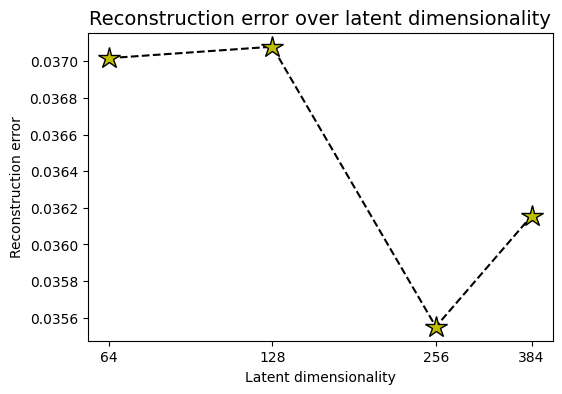

In [ ]:
# Ordena las dimensiones latentes disponibles
latent_dims = sorted([k for k in model_dict])

# Obtiene los errores de validación para cada dimensión latente
val_scores = [model_dict[k]["result"] for k in latent_dims]

# Grafica el error de reconstrucción vs. dimensión latente
fig = plt.figure(figsize=(6,4))
plt.plot(latent_dims, val_scores, '--', color="#000", marker="*", markeredgecolor="#000", markerfacecolor="y", markersize=16)
plt.xscale("log")
plt.xticks(latent_dims, labels=latent_dims)
plt.title("Reconstruction error over latent dimensionality", fontsize=14)
plt.xlabel("Latent dimensionality")
plt.ylabel("Reconstruction error")
plt.minorticks_off()
plt.show()


In [ ]:
# Elegir el latent_dim con menor test_loss
best_latent_dim = min(model_dict, key=lambda k: model_dict[k]['result'])

# Obtener el trainer del mejor modelo
best_trainer = model_dict[best_latent_dim]['trainer']

print(f"Latent dim con menor error: {best_latent_dim}, pérdida: {model_dict[best_latent_dim]['result']:.4f}")

Latent dim con menor error: 256, pérdida: 0.0356


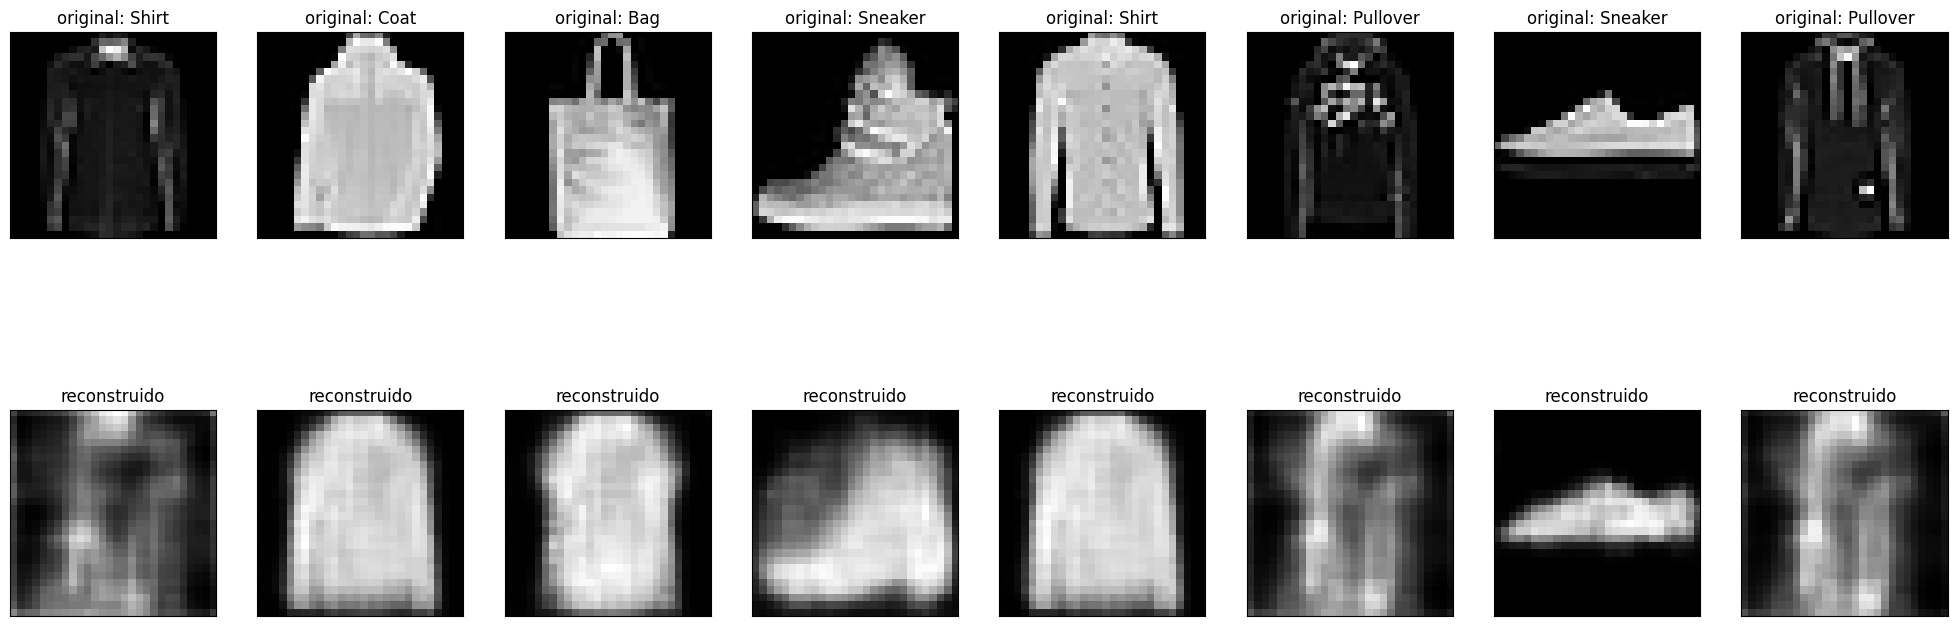

In [ ]:
plt.figure(figsize=(25, 9))
for idx, (ds, lb) in enumerate(data_unseen.take(8)):
    # Convertir imagen de TensorFlow a NumPy y añadir dimensión batch
    img = ds[0].numpy()           # [32, 32, 3]
    img = jnp.expand_dims(img, 0) # [1, 32, 32, 3]
    label = lb[0].numpy()

    # Mostrar imagen original
    ax = plt.subplot(2, 8, idx + 1)
    plt.title("original: {}".format(label_names[label]))
    plt.imshow(jnp.squeeze(img))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstrucción
    recon = best_trainer.model_bd(img)

    # Mostrar reconstruida
    bx = plt.subplot(2, 8, idx + 8 + 1)
    plt.title("reconstruido")
    plt.imshow(jnp.squeeze(recon))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)


In [ ]:
import pandas as pd
from tqdm import tqdm  # Opcional: para ver progreso

list_latent = []
list_latent_label = []

# Extraer embeddings desde el encoder JAX (model_bd)
for idx, (ds, lb) in tqdm(enumerate(data_unseen.take(100))):
    img = ds[0].numpy()                          # Extraer imagen
    img = jnp.expand_dims(img, axis=0)           # Añadir dimensión batch
    label = lb[0].numpy().tolist()               # Obtener etiqueta

    # Obtener latente desde el modelo vinculado
    latent_vector = trainer_ld.model_bd.encode(img)
    latent_vector = jnp.squeeze(latent_vector)   # Quitar dimensión extra

    # Convertir a lista para almacenar
    list_latent.append(latent_vector.tolist())
    list_latent_label.append(label_names[label])

# Convertir latentes a DataFrame
def df_(list_data, list_label):
    x = [i[0] for i in list_data]
    y = [i[1] for i in list_data]
    df = pd.DataFrame(zip(x, y, list_label), columns=['x', 'y', 'rotulos'])
    return df

df = df_(list_latent, list_latent_label)


100it [00:02, 43.45it/s]


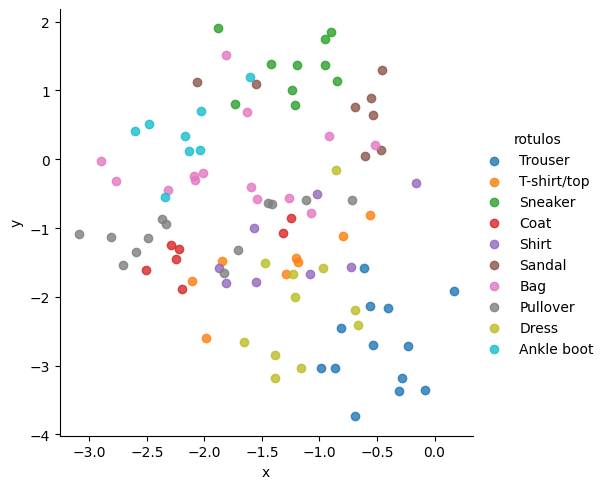

In [ ]:
import seaborn as sns
sns.lmplot( x="x", y="y", data=df, fit_reg=False, hue='rotulos', legend=True)

In [ ]:
def find_similar_images(query_img, query_z, key_embeds, K=8):
    # Encontrar las K imágenes más cercanas. Usamos distancia euclidiana, aunque también podría usarse distancia coseno, etc.
    dist = np.linalg.norm(query_z[None, :] - key_embeds[1], axis=-1)
    indices = np.argsort(dist)
    dist = dist[indices]

    # Graficar las K imágenes más cercanas
    imgs_to_display = np.concatenate([query_img[None], key_embeds[0][indices[:K]]], axis=0)
    imgs_to_display = torch.from_numpy(imgs_to_display)
    imgs_to_display = imgs_to_display.permute(0, 3, 1, 2)  # Cambiar a formato (N, C, H, W)

    grid = torchvision.utils.make_grid(imgs_to_display, nrow=K+1, normalize=True, value_range=(-1, 1))
    grid = grid.permute(1, 2, 0)  # Volver a formato (H, W, C) para visualizar con matplotlib

    plt.figure(figsize=(12, 3))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

In [ ]:
def embed_imgs(trainer, data_loader, max_batches=8):
    img_list, embed_list = [], []

    @jax.jit
    def encode(imgs):
        return trainer.model_bd.encoder(imgs)

    for i, (batch_imgs, _) in enumerate(tqdm(data_loader, desc="Encoding images", leave=False)):
        if i >= max_batches:
            break

        # Convertir TF tensor a numpy y luego a jax array
        imgs_np = batch_imgs.numpy() if hasattr(batch_imgs, 'numpy') else np.array(batch_imgs)
        imgs_jax = jnp.array(imgs_np)

        z = encode(imgs_jax)
        z = jax.device_get(z)

        img_list.append(imgs_np)
        embed_list.append(z)

    return np.concatenate(img_list, axis=0), np.concatenate(embed_list, axis=0)


In [ ]:
import matplotlib.pyplot as plt

def find_and_plot_similar_images(query_imgs, query_embeds, imgs_all, embeds_all, K=8):
    plt.figure(figsize=(20, 16))

    for i, (q_img, q_embed) in enumerate(zip(query_imgs, query_embeds)):
        # Calcular distancias euclidianas a todos los embeddings
        dists = np.linalg.norm(embeds_all - q_embed[None, :], axis=1)
        indices = np.argsort(dists)

        # Mostrar la consulta en la primera columna
        ax = plt.subplot(8, K + 1, i * (K + 1) + 1)
        plt.imshow(q_img)
        plt.title("Consulta")
        plt.axis('off')

        # Mostrar las K imágenes más similares al lado
        for j in range(K):
            similar_img = imgs_all[indices[j]]
            ax = plt.subplot(8, K + 1, i * (K + 1) + 2 + j)
            plt.imshow(similar_img)
            plt.title(f"Sim {j+1}")
            plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
imgs_all, embeds_all = embed_imgs(trainer_ld, data_train)  # todos los imgs + embeddings

# Tomamos las primeras 8 imágenes como consultas
query_imgs = imgs_all[:8]
query_embeds = embeds_all[:8]

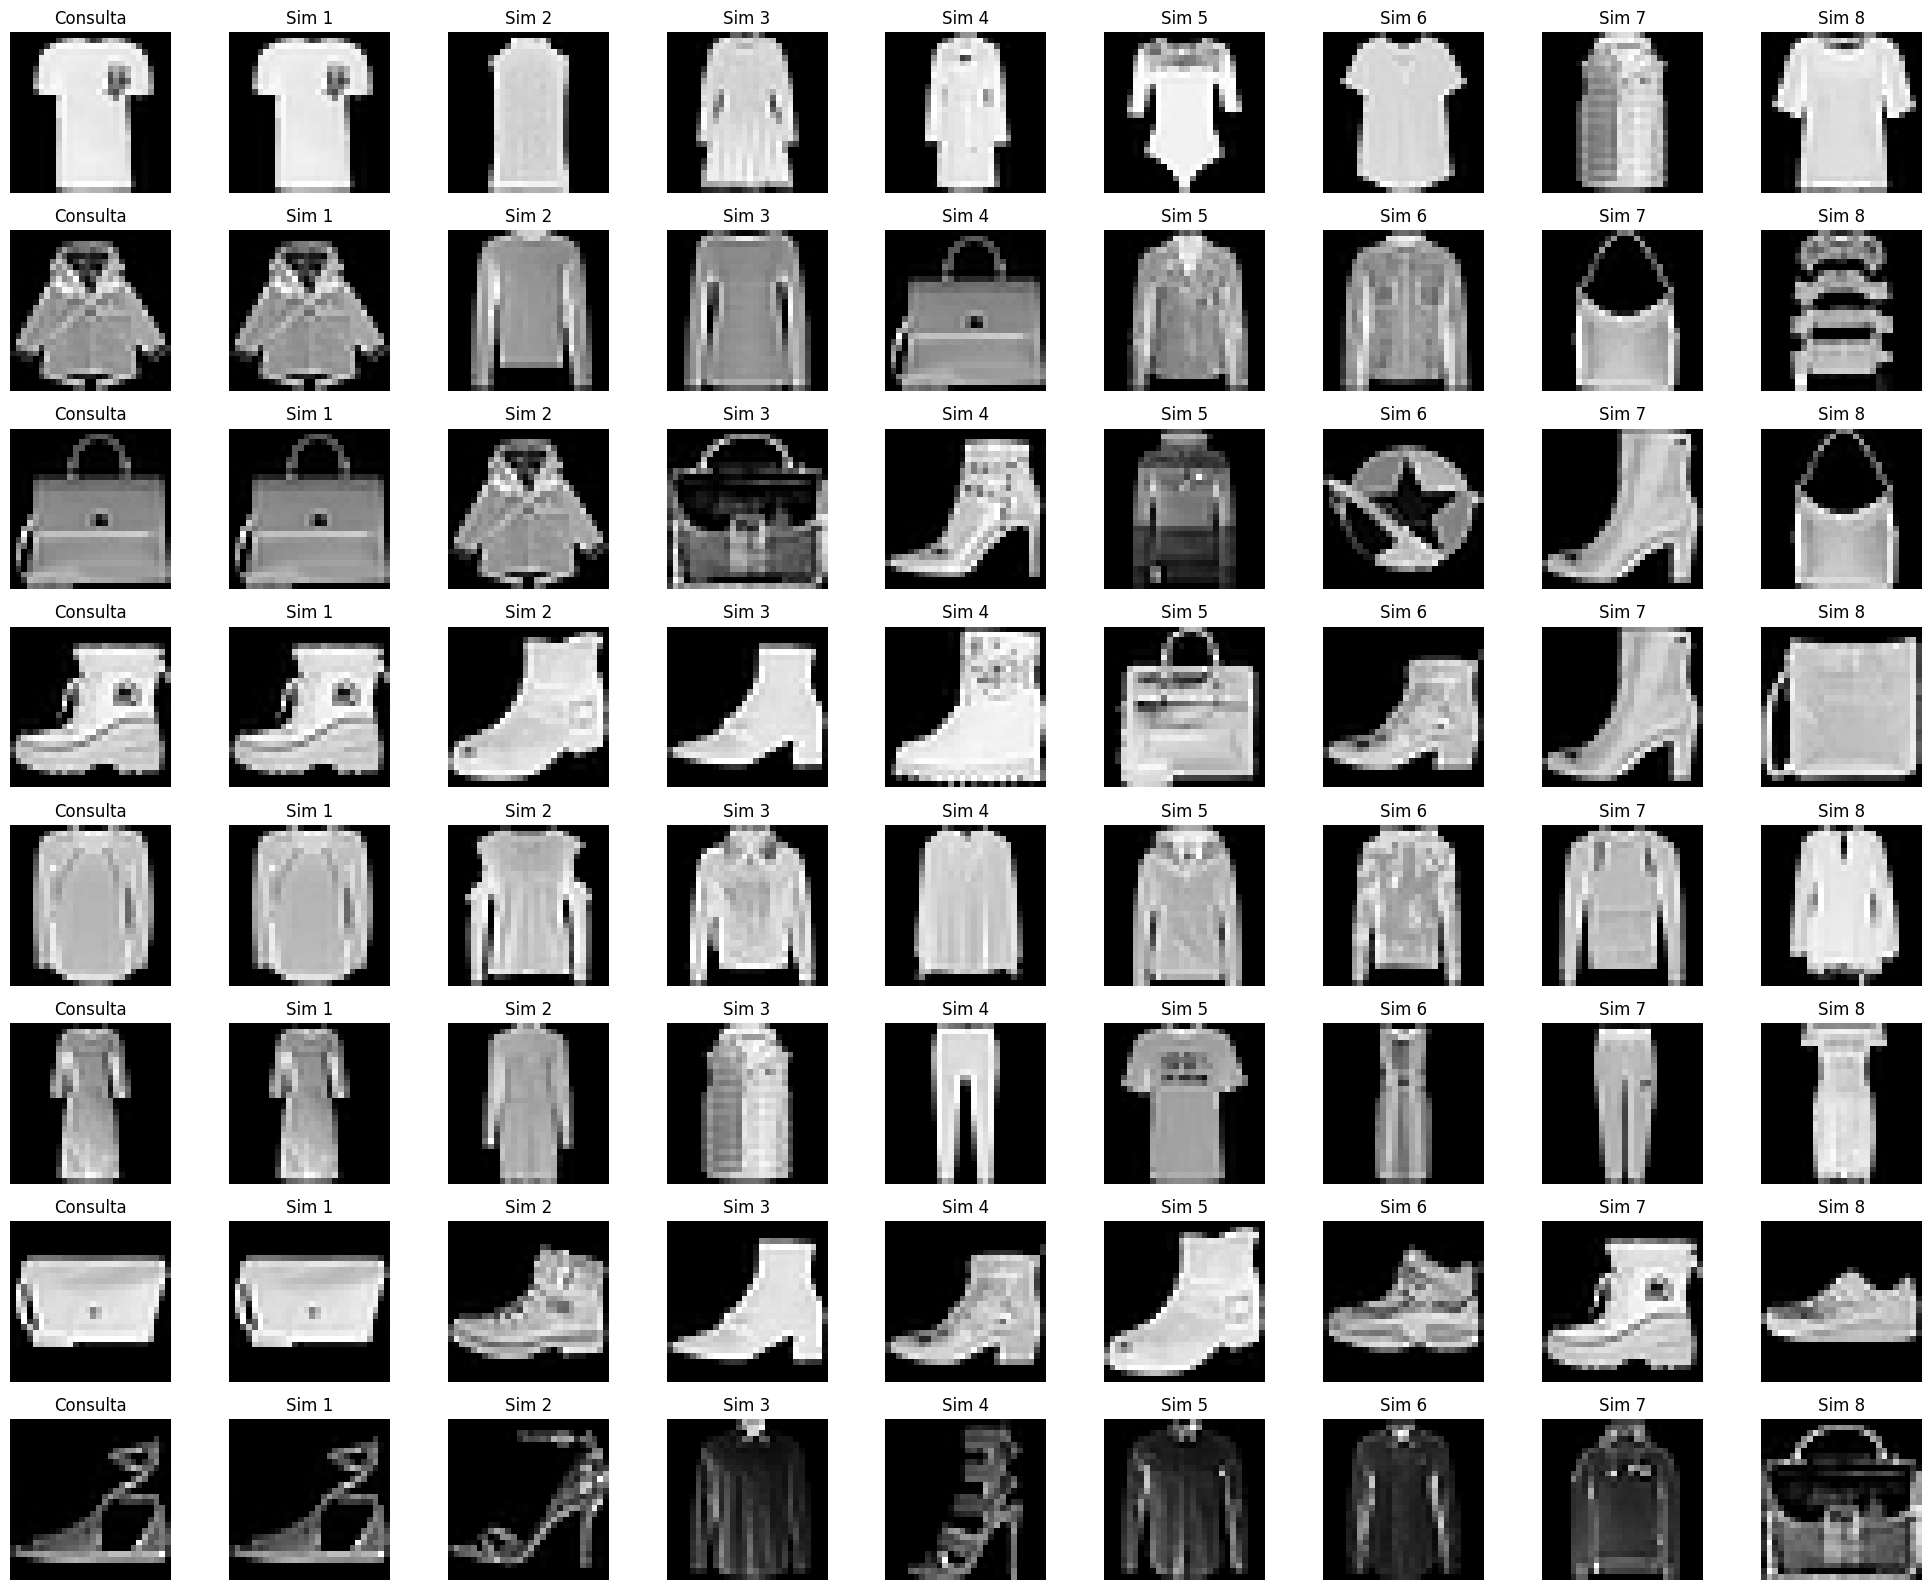

In [ ]:
# Paso 1: Obtener embeddings de todo un dataset
train_img_embeds = embed_imgs(trainer_ld, data_train, max_batches=8)
test_img_embeds = embed_imgs(trainer_ld, data_train, max_batches=8)

# Paso 2: Elegir una imagen de consulta (ejemplo, la imagen 5 del test set)
query_img = test_imgs[5]
query_img_jax = jnp.expand_dims(query_img, axis=0)  # Añadimos batch dim

# Paso 3: Obtener embedding de la imagen consulta
query_z = trainer_ld.model_bd.encoder(query_img_jax)
query_z = jax.device_get(query_z).squeeze()

# Paso 4: Buscar y mostrar las imágenes similares
find_and_plot_similar_images(query_imgs, query_embeds, imgs_all, embeds_all, K=8)

In [ ]:
def augment_data_noisy(images, labels, get_label=False):

    noise = tf.random.normal(shape=tf.shape(images), mean=0.0, stddev=0.3, dtype=tf.float32)

    if get_label:
        return tf.cast(images, tf.float32) / 255.+ noise,labels
    else:
        return tf.cast(images, tf.float32) / 255.+ noise, tf.cast(images, tf.float32) / 255.

In [ ]:
data_train_no = data_load(ds_train_,augmented=augment_data_noisy)
data_val_no = data_load(ds_val_,augmented=augment_data_noisy)
data_test_no = data_load(ds_test_,augmented=augment_data_noisy,shuffle_=False)
data_unseen_no = data_load(ds_unseen,augmented=augment_data_noisy,get_label=True )

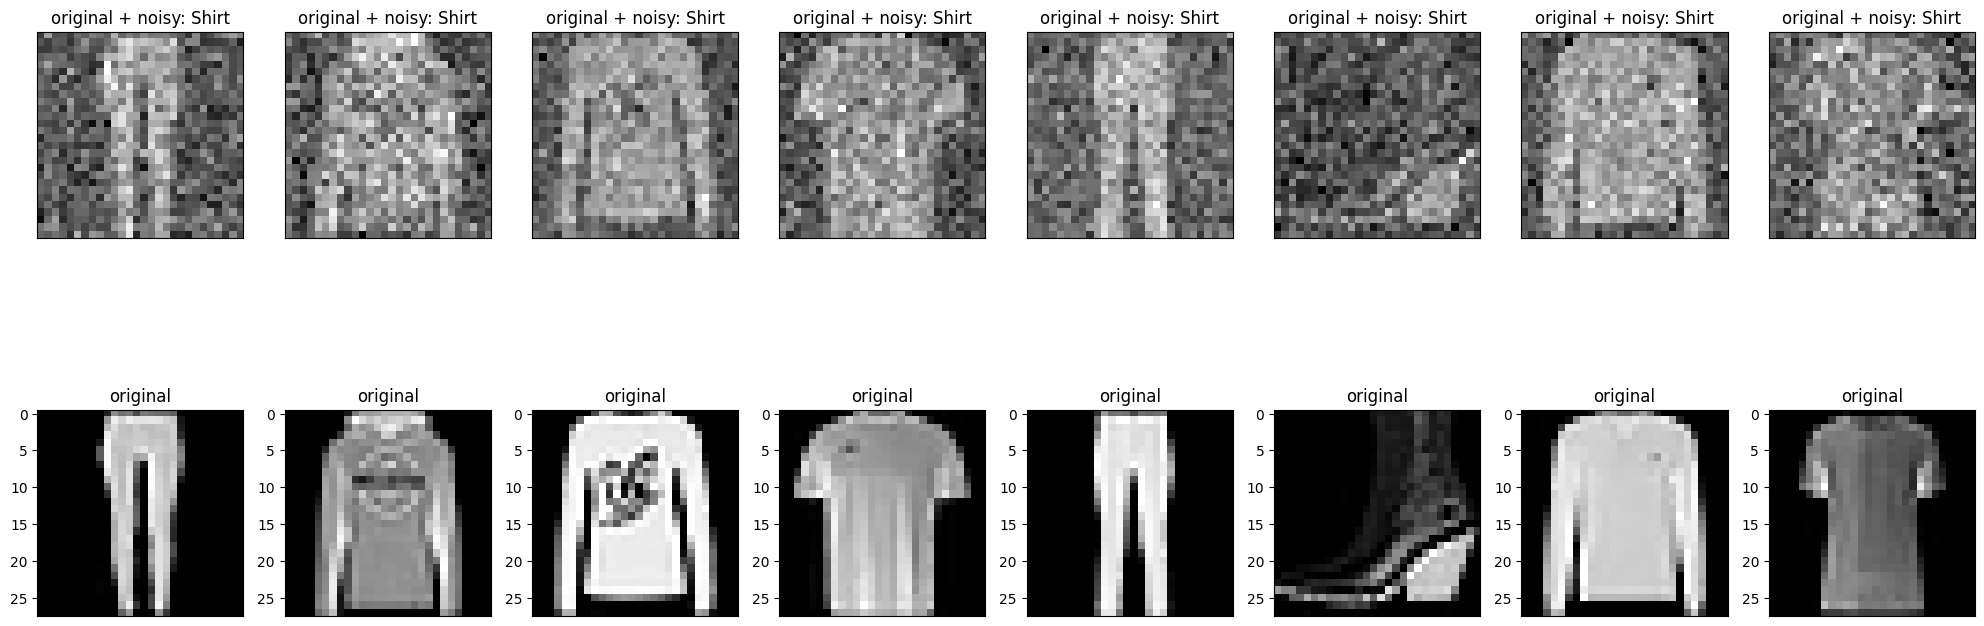

In [ ]:
plt.figure(figsize=(25, 9))
for idx,(ds_no,ds) in enumerate(data_train_no.take(8)):
    ax = plt.subplot(2, 8, idx + 1)
    plt.title("original + noisy: {}".format(label_names[lb[0]]))
    plt.imshow(tf.squeeze(ds_no[0]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    bx = plt.subplot(2, 8, idx + 8 + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(ds[0]))
    plt.gray()
    bx.get_xaxis().set_visible(False)

In [ ]:
# Crear instancia nueva con los mismos hiperparámetros
autoencoder_denoising = Autoencoder(encoded_size=autoencoder.encoded_size, base_depth=autoencoder.base_depth)

In [ ]:
model_dict = {}
for latent_dim in [64, 128, 256, 384]:
    trainer_ld, test_loss_ld = train(latent_dim, autoencoder_denoising)
    model_dict[latent_dim] = {"trainer": trainer_ld, "result": test_loss_ld}

Época 1, pérdida promedio: 0.0445


In [ ]:
def plot_unseen_reconstructions(data_unseen_no, trainer, label_names):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(25, 9))
    count = 0

    for batch_imgs, batch_labels in data_unseen_no:
        for i in range(batch_imgs.shape[0]):
            if count >= 8:
                break

            # Tomar imagen individual
            img = batch_imgs[i].numpy()  # (28, 28, 1)
            lbl = batch_labels[i].numpy()

            # Prepara imagen para JAX (shape: (1, 28, 28, 1))
            img_input = jnp.expand_dims(jnp.array(img), axis=0)

            # Reconstrucción
            recon = trainer.model.apply({'params': trainer.state.params}, img_input)
            recon = np.array(recon[0])  # remove batch dimension

            # Plot original
            ax = plt.subplot(2, 8, count + 1)
            plt.title(f"original: {label_names[lbl]}")
            plt.imshow(np.squeeze(img), cmap="gray")
            ax.axis('off')

            # Plot reconstrucción
            bx = plt.subplot(2, 8, count + 9)
            plt.title("reconstruido")
            plt.imshow(np.squeeze(recon), cmap="gray")
            bx.axis('off')

            count += 1

        if count >= 8:
            break

    plt.tight_layout()
    plt.show()


In [ ]:
plot_unseen_reconstructions(data_unseen_no, trainer_ld, label_names)